### Fetching Data

In [1]:
# from SoccerNet.Downloader import SoccerNetDownloader as SNdl
# mySNdl = SNdl(LocalDirectory="path/to/SoccerNet")
# mySNdl.downloadDataTask(task="jersey-2023", split=["train","test","challenge"])

In [2]:
import pathlib
import tensorflow as tf
import numpy as np
import os
import keras
import json
import cv2
from matplotlib import pyplot as plt
import zipfile

In [11]:
"""
This function will load the data and return two zipped arrays: 

output:       contains an image stored as a numpy array
class_labels: contains the corresponding label for each element of output

@params
dir: should be the path that contains both train images, and json dic with labels
save: If you want it to save the output as a zip file (so you don't have to do this twice)
"""

def load_data(dir, save = False):

    #labels is a dictionary mapping file_numer ->class_label
    with open(dir + "/train_gt.json") as file:
        labels = json.load(file)

    #converts an image to a numpy array
        
    """
    Eventually we will want to resize the images when we localize. This is just so that they are all the same size.
    """
    get_image = lambda file_name: cv2.resize(cv2.imread(file_name),(40, 100))

    output = []
    class_labels = []

    #iterate through the folders, convert the images to RGB arrays, and then append the class label
    for folder in list(os.listdir(dir+"/images")):

        if folder == '.DS_Store': continue
        #if (folder != '1' and folder != '2'): continue

        cls = labels[folder]
        images = os.listdir(os.path.join(dir+"/images", folder))

        for image in images:
            output.append(get_image(os.path.join(dir+"/images", folder, image)))
            class_labels.append(cls)

    zip_file = zip(output, class_labels)
    if save:
        np.savez_compressed(dir+"/numpy_data.npz", output, labels)
        
    return zip_file


In [44]:
def load_small_data(dir):

    data = np.load(dir)
    lst = data.files
    X = data[lst[0]]
    y = data[lst[1]]

    return X,y

In [84]:
#X,y = zip(*load_data("/Users/omarafifi/Downloads/Jersey Detection/train", False))
X,y = load_small_data('/Users/omarafifi/Downloads/Jersey Detection/train/jersey_sample.npz')

### Preprocessing

In [12]:
from keras import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, ZeroPadding2D
from sklearn.model_selection import train_test_split

In [91]:
# right now, there is no data processing. 
# But, We need to make sure that all the images have the same shape.
# and one hot encode y labels
def process_data(X_data, y_data):

    """
    Prepare the response:

    This part of the function just basically maps the classes to the set {0, ... 44}, and then one-hot encodes the response
    """
    #for to_categorical to work, we need to map the labels to {0, ... 44}
    label_to_int = {}
    int_to_label = {}

    for index, label in enumerate(np.unique(y_data)):
        label_to_int[label]=index
        int_to_label[index]=label

    
    y_data_new = np.vectorize(label_to_int.__getitem__)(y_data)
    y_data_new = to_categorical(y_data_new)

    #X_train, y_train = zip(*load_data(directory, True))
    X_data = np.array(X_data)


    return X_data, y_data_new


In [92]:
X_train, y_train = process_data(X,y)

y_train.shape

(36650, 45)

### Prepare data

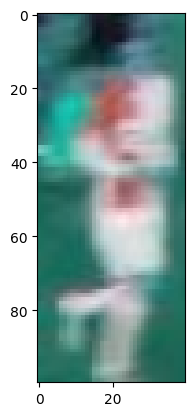

In [101]:
plt.imshow(X[82])

### Model Construction

In [104]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (4,4), activation = 'relu', input_shape = (100,40,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32, kernel_size = (4,4), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (4,4), activation = 'relu'))
model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 45, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['Accuracy'])

### Fit the model

In [105]:
model.fit(x = X_train, batch_size=5, epochs=20, y = y_train)

Epoch 1/20
7330/7330 [==============================] - 63s 9ms/step - loss: 2.5641 - Accuracy: 0.2854
Epoch 2/20
7330/7330 [==============================] - 65s 9ms/step - loss: 2.1961 - Accuracy: 0.3459
Epoch 3/20
7330/7330 [==============================] - 68s 9ms/step - loss: 2.0841 - Accuracy: 0.3804
Epoch 4/20
7330/7330 [==============================] - 69s 9ms/step - loss: 1.9727 - Accuracy: 0.4076
Epoch 5/20
7330/7330 [==============================] - 68s 9ms/step - loss: 1.9052 - Accuracy: 0.4267
Epoch 6/20
7330/7330 [==============================] - 70s 10ms/step - loss: 1.8058 - Accuracy: 0.4527
Epoch 7/20
7330/7330 [==============================] - 66s 9ms/step - loss: 1.8062 - Accuracy: 0.4588
Epoch 8/20
7330/7330 [==============================] - 68s 9ms/step - loss: 2.0018 - Accuracy: 0.4063
Epoch 9/20
7330/7330 [==============================] - 68s 9ms/step - loss: 1.9392 - Accuracy: 0.4216
Epoch 10/20
7330/7330 [==============================] - 69s 9ms/step - 

## Things To do: 

1) Use GridSearchCV to impletent CV so we can tune hyperparamaters